In [1]:
import pandas as pd
import numpy as numpy
import os
import sumolib
import copy
from tqdm import tqdm
from datetime import datetime

In [2]:
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fmins = range(midnight, next_day, 300)
m = 100 # m ranges from 26 to 287
print(fmins[m])
net = sumolib.net.readNet('../../Data/networks/SN_sample.net.xml')
inter_node = pd.read_csv('../../data/tables/inter_node.csv', index_col=0)
inter_node = inter_node[inter_node.inter_type=='parent']
histid = pd.read_csv(f'../../Data/tables/histids/histids_{fmins[m]}.csv', index_col=0)
histid = histid[histid.inter_no.isin(inter_node.inter_no.unique())]
inter2node = dict(zip(inter_node['inter_no'], inter_node['node_id']))
histid['node_id'] = histid['inter_no'].map(inter2node)
histid = histid[['node_id', 'start_unix', 'phas_A', 'phas_B', 'duration', 'inc_edge_A', 'inc_edge_B', 'out_edge_A', 'out_edge_B', 'move_A', 'move_B']]
histid = histid.reset_index(drop=True)
histid

1704410400


node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
0        i1  1704406840       1       1        37  -571542810_01   
1        i1  1704406840       2       2        93  -571542810_01   
2        i1  1704406840       3       3        40   571543469_02   
3        i9  1704406850       1       1        46   571510152_02   
4        i9  1704406850       2       2       114            NaN   
..      ...         ...     ...     ...       ...            ...   
477      i6  1704410200       4       4        23   571500585_02   
478      i2  1704410220       1       1        40  -571542809_01   
479      i2  1704410220       2       2        25   571542811_02   
480      i2  1704410220       3       3        71            NaN   
481      i2  1704410220       4       4        34  -571542809_01   

          inc_edge_B        out_edge_A       out_edge_B  move_A  move_B  
0    571542797_02.99  -571542797_02.99     571542810_01       8       4  
1      -571542810_01  -571542797_02.99     571543469_01       8       3  
2                NaN  -571542797_02.99              NaN       5      18  
3       571510152_01     -571510152_01  571510152_01.65       6       2  
4                NaN               NaN              NaN      17      18  
..               ...               ...              ...     ...     ...  
477     571500585_02      571511538_01     571500535_01       8       3  
478     571542811_02      571542811_01     571542809_01       8       4  
479    -571542809_01      571542107_01     571542809_01       7       3  
480              NaN               NaN              NaN      17      18  
481     571542107_02      571542811_01     571542809_01       5       1  

[482 rows x 11 columns]

In [3]:
sigtable = histid.copy()
node_ids = sorted(sigtable.node_id.unique())
nodes = [net.getNode(node_id) for node_id in node_ids]
print(node_ids)
print(nodes)

['i0', 'i1', 'i2', 'i3', 'i6', 'i7', 'i8', 'i9']
[<junction id="i0"/>, <junction id="i1"/>, <junction id="i2"/>, <junction id="i3"/>, <junction id="i6"/>, <junction id="i7"/>, <junction id="i8"/>, <junction id="i9"/>]


In [4]:
node2init = {}
for node in nodes:
    node_id = node.getID()
    conns = [(c.getJunctionIndex(), c) for c in node.getConnections()]
    conns = [c for c in conns if c[0] >= 0]
    conns = sorted(conns, key=lambda x: x[0])
    state = []
    for i, ci in conns:
        if ci.getTLLinkIndex() < 0:
            continue
        are_foes = False
        for j, cj in conns:
            if ci.getTo() == cj.getTo():
                continue
            if node.areFoes(i, j):
                are_foes = True
                break
        state.append('r' if are_foes else 'g')
    node2init[node_id] = state

# 어떤 연결과도 상충이 일어나지는 않지만, 신호가 부여되어 있는 경우에는 r을 부여
for _, row in sigtable.iterrows():
    node_id = row['node_id']
    inc_edge_A = row.inc_edge_A
    inc_edge_B = row.inc_edge_B
    out_edge_A = row.out_edge_A
    out_edge_B = row.out_edge_B
    move_A = row['move_A']
    move_B = row['move_B']

    if pd.isna(inc_edge_A) or pd.isna(out_edge_A):
        continue
    else:
        inc_edge_A = net.getEdge(inc_edge_A)
        out_edge_A = net.getEdge(out_edge_A)
        for conn in inc_edge_A.getConnections(out_edge_A):
            index = conn.getTLLinkIndex()
            if index >= 0:
                node2init[node_id][index] = 'r'

    if pd.isna(inc_edge_B) or pd.isna(out_edge_B):
        continue
    else:
        inc_edge_B = net.getEdge(inc_edge_B)
        out_edge_B = net.getEdge(out_edge_B)
        for conn in inc_edge_B.getConnections(out_edge_B):
            index = conn.getTLLinkIndex()
            if index >= 0:
                node2init[node_id][index] = 'r'
for node_id in node_ids:
    print(node_id, "".join(node2init[node_id]))

i0 grrrgrrrgrrrrrgrr
i1 grrrrrrgrr
i2 rrggrrr
i3 grrrrgrrrrgrrrrgrrrr
i6 grrrgrrrrgrrgrrr
i7 rrrggrr
i8 grrrrrrrgrrrgrrr
i9 rrrr


In [5]:
print(node2init['i6'])
state = copy.deepcopy(node2init)['i6']
state[0] = 'G'
print(state)
print(node2init['i6'])

['g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'r']
['G', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'r']
['g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'r']


(array([ 1.,  7., 11., 12.,  6.,  7.,  3.,  1.,  2.,  3.]),
 array([  0. ,  12.2,  24.4,  36.6,  48.8,  61. ,  73.2,  85.4,  97.6,
        109.8, 122. ]),
 <BarContainer object of 10 artists>)

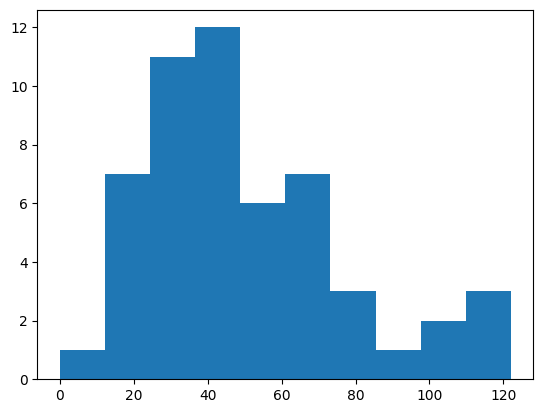

In [6]:
plan = pd.read_csv('../../Data/tables/plan.csv', index_col=0)
durs = plan[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].values.flatten()
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.unique(durs))

In [19]:
sigtable = histid.copy()
sigtable['init_state'] = sigtable['node_id'].map(node2init)
for i, row in sigtable.iterrows():
    node_id = row.node_id
    inc_edge_A = row.inc_edge_A
    inc_edge_B = row.inc_edge_B
    out_edge_A = row.out_edge_A
    out_edge_B = row.out_edge_B
    state = copy.deepcopy(node2init)[node_id]

    if pd.isna(inc_edge_A) or pd.isna(out_edge_A):
        continue
    else:
        inc_edge_A = net.getEdge(inc_edge_A)
        out_edge_A = net.getEdge(out_edge_A)
        for conn in inc_edge_A.getConnections(out_edge_A):
            index = conn.getTLLinkIndex()
            if index >= 0:
                state[index] = 'G'
        sigtable.at[i, 'state'] = ''.join(state)

    if pd.isna(inc_edge_B) or pd.isna(out_edge_B):
        continue
    else:
        inc_edge_B = net.getEdge(inc_edge_B)
        out_edge_B = net.getEdge(out_edge_B)
        for conn in inc_edge_B.getConnections(out_edge_B):
            index = conn.getTLLinkIndex()
            if index >= 0:
                state[index] = 'G'
        sigtable.at[i, 'state'] = ''.join(state)
sigtable = sigtable.dropna(subset='state')
sigtable = sigtable.reset_index(drop=True)
sigtable['phase_sumo'] = sigtable.groupby(['node_id', 'start_unix']).cumcount()
sigtable = sigtable[['node_id', 'start_unix', 'phase_sumo', 'duration', 'state']]
sigtable = sigtable.sort_values(by=['start_unix', 'node_id'])
sigtable_dt = sigtable.copy()[sigtable.start_unix >= fmins[m]-360]
sigtable_dt['start_dt'] = sigtable_dt['start_unix'].apply(lambda x:datetime.fromtimestamp(x))
sigtable_dt = sigtable_dt[sigtable_dt.node_id!='i9']
sigtable_dt = sigtable_dt[sigtable_dt.node_id!='i2']
display(sigtable_dt)

node_id  start_unix  phase_sumo  duration              state  \
399      i7  1704410130           0        44            GGrggGG   
400      i7  1704410130           1        26            GGrggGG   
401      i0  1704410170           0        40  gGGrgrrrgGGGGrgrr   
402      i0  1704410170           1        42  grrGgrrrgrrrrGgrr   
403      i0  1704410170           2        29  grrrgGGGgrrrrrgrr   
404      i0  1704410170           3        26  grrrgGGrgrrrrrgGr   
405      i0  1704410170           4        33  grrrgrrrgrrrrrgGG   
406      i6  1704410200           0        24   grrrgGGGrgrrgrrr   
407      i6  1704410200           1        19   grrrgGGGrgrrgGGr   
408      i6  1704410200           2        39   grrrgrrrrgrrgGGG   
409      i6  1704410200           3        65   gGGGgrrrrgrrgrrr   
410      i6  1704410200           4        23   grrrgrrrrgGGgrrr   

               start_dt  
399 2024-01-05 08:15:30  
400 2024-01-05 08:15:30  
401 2024-01-05 08:16:10  
402 2024-01-05 08:16:10  
403 2024-01-05 08:16:10  
404 2024-01-05 08:16:10  
405 2024-01-05 08:16:10  
406 2024-01-05 08:16:40  
407 2024-01-05 08:16:40  
408 2024-01-05 08:16:40  
409 2024-01-05 08:16:40  
410 2024-01-05 08:16:40

In [8]:
print(sigtable.start_unix.max() - sigtable.start_unix.min())
print(datetime.fromtimestamp(fmins[m - 1]))
print(datetime.fromtimestamp(fmins[m]))
print(datetime.fromtimestamp(sigtable.start_unix.max()))
print(datetime.fromtimestamp(sigtable.start_unix.min()))

3380
2024-01-05 08:15:00
2024-01-05 08:20:00
2024-01-05 08:17:00
2024-01-05 07:20:40


In [9]:
sigtable1 = sigtable.copy()


In [ ]:
sorted(sigtable.node_id.unique())

['i0', 'i1', 'i2', 'i3', 'i6', 'i7', 'i8', 'i9']

In [ ]:
strings = ['<tlLogics>\n']
for key, group in sigtable.groupby(['start_unix', 'node_id']):
    start_unix = key[0]
    node_id = key[1]
    strings.append(f'    <tlLogic id="{node_id}" type="traffic_light" programID="{key}" offset="{start_unix}">\n')
    for i, row in group.iterrows():
        duration = row.duration
        state = row.state
        strings.append(f'      <phase duration="{duration}" state="{state}"/>\n')
    strings.append('    </tlLogic>\n')


In [ ]:
strings = ['<tlLogics>\n']
for key, group in sigtable.groupby(['start_unix', 'node_id']):
    start_unix = key[0]
    node_id = key[1]
    strings.append(f'    <tlLogic id="{node_id}" type="traffic_light" programID="{key}" offset="{start_unix}">\n')
    for i, row in group.iterrows():
        duration = row.duration
        state = row.state
        strings.append(f'      <phase duration="{duration}" state="{state}"/>\n')
    strings.append('    </tlLogic>\n')
strings.append('</tlLogics>')
strings = ''.join(strings)
# 저장
path_output = '../../Data/networks/SN_sample.tll.xml'
with open(path_output, 'w') as f:
    f.write(strings)
print(strings)

<tlLogics>
    <tlLogic id="i6" type="traffic_light" programID="(1704403210, 'i6')" offset="1704403210">
      <phase duration="24" state="grrrgGGGrgrrgrrr"/>
      <phase duration="19" state="grrrgGGGrgrrgGGr"/>
      <phase duration="29" state="grrrgrrrrgrrgGGG"/>
      <phase duration="56" state="gGGGgrrrrgrrgrrr"/>
      <phase duration="22" state="grrrgrrrrgGGgrrr"/>
    </tlLogic>
    <tlLogic id="i9" type="traffic_light" programID="(1704403210, 'i9')" offset="1704403210">
      <phase duration="39" state="GGGG"/>
    </tlLogic>
    <tlLogic id="i3" type="traffic_light" programID="(1704403220, 'i3')" offset="1704403220">
      <phase duration="38" state="gGGGrgrrrrgGGGrgrrrr"/>
      <phase duration="39" state="grrrGgrrrrgrrrGgrrrr"/>
      <phase duration="40" state="grrrrgrrrrgrrrrgGGGG"/>
      <phase duration="23" state="grrrrgGGGGgrrrrgrrrr"/>
    </tlLogic>
    <tlLogic id="i2" type="traffic_light" programID="(1704403230, 'i2')" offset="1704403230">
      <phase duration="3

In [ ]:
strings = ['<tlLogics>\n']
for key, group in sigtable.groupby(['start_unix', 'node_id']):
    start_unix = key[0]
    node_id = key[1]
    strings.append(f'    <tlLogic id="{node_id}" type="traffic_light" programID="{key}" offset="{start_unix}">\n')
    for i, row in group.iterrows():
        duration = row.duration
        state = row.state
        strings.append(f'      <phase duration="{duration}" state="{state}"/>\n')
    strings.append('    </tlLogic>\n')
strings.append('</tlLogics>')
strings = ''.join(strings)
# 저장
path_output = '../../Data/networks/SN_sample.tll.xml'
with open(path_output, 'w') as f:
    f.write(strings)
print(strings)

<tlLogics>
    <tlLogic id="i6" type="traffic_light" programID="(1704403210, 'i6')" offset="1704403210">
      <phase duration="24" state="grrrgGGGrgrrgrrr"/>
      <phase duration="19" state="grrrgGGGrgrrgGGr"/>
      <phase duration="29" state="grrrgrrrrgrrgGGG"/>
      <phase duration="56" state="gGGGgrrrrgrrgrrr"/>
      <phase duration="22" state="grrrgrrrrgGGgrrr"/>
    </tlLogic>
    <tlLogic id="i9" type="traffic_light" programID="(1704403210, 'i9')" offset="1704403210">
      <phase duration="39" state="GGGG"/>
    </tlLogic>
    <tlLogic id="i3" type="traffic_light" programID="(1704403220, 'i3')" offset="1704403220">
      <phase duration="38" state="gGGGrgrrrrgGGGrgrrrr"/>
      <phase duration="39" state="grrrGgrrrrgrrrGgrrrr"/>
      <phase duration="40" state="grrrrgrrrrgrrrrgGGGG"/>
      <phase duration="23" state="grrrrgGGGGgrrrrgrrrr"/>
    </tlLogic>
    <tlLogic id="i2" type="traffic_light" programID="(1704403230, 'i2')" offset="1704403230">
      <phase duration="3